In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import pickle

# Created Data Exploration

In [2]:
with open('data/consecutive_games_df.pkl', 'rb') as handle:
    df = pickle.load(handle)

In [3]:
df['time_between_games'] = (df['next_date'] - df['prev_date']).apply(lambda x: x.days)

In [4]:
df = df[(df['prev_goal_diff'] == 1) | (df['prev_goal_diff'] == -1)]

In [5]:
df['lost_prev_game'] = df['prev_goal_diff'] < 0

In [6]:
df.columns

Index(['row_team', 'season', 'league_id', 'row_team_wins', 'row_team_draws',
       'row_team_league_points', 'row_team_season_goals', 'prev_match_api_id',
       'prev_date', 'prev_home', 'prev_goal_diff', 'prev_mean_bet_row_team',
       'prev_mean_bet_rival', 'prev_mean_bet_draw',
       'prev_row_team_min_squad_rating', 'prev_rival_team_min_squad_rating',
       'prev_row_team_max_squad_rating', 'prev_rival_team_max_squad_rating',
       'prev_row_team_mean_squad_rating', 'prev_rival_team_mean_squad_rating',
       'prev_row_team_std_squad_rating', 'prev_rival_team_std_squad_rating',
       'prev_row_team_median_squad_rating',
       'prev_rival_team_median_squad_rating', 'prev_row_team_goal',
       'prev_rival_team_api_id', 'prev_rival_wins', 'prev_rival_draws',
       'prev_rival_league_points', 'prev_rival_season_goals',
       'prev_rival_team_goal', 'next_match_api_id', 'next_date', 'next_home',
       'next_goal_diff', 'next_mean_bet_row_team', 'next_mean_bet_rival',
       

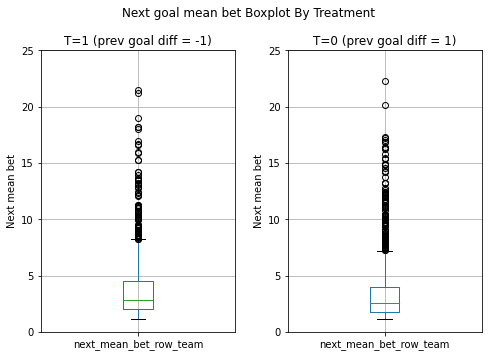

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5))
fig.suptitle('Next goal mean bet Boxplot By Treatment')
ax1 = axs[0]
ax1.set_ylim(0, 25)
ax1.set_title('T=1 (prev goal diff = -1)')
ax1.set_ylabel('Next mean bet')
ax2 = axs[1]
ax2.set_ylim(0, 25)
ax2.set_title('T=0 (prev goal diff = 1)')
ax2.set_ylabel('Next mean bet')
fig.tight_layout()
df[df['prev_goal_diff'] == -1][['next_mean_bet_row_team']].boxplot(ax=axs[0])
df[df['prev_goal_diff'] == 1][['next_mean_bet_row_team']].boxplot(ax=axs[1]);


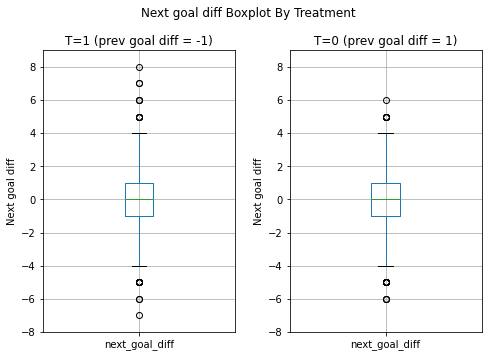

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5))
fig.suptitle('Next goal diff Boxplot By Treatment')
ax1 = axs[0]
ax1.set_ylim(-8, 9)
ax1.set_title('T=1 (prev goal diff = -1)')
ax1.set_ylabel('Next goal diff')
ax2 = axs[1]
ax2.set_ylim(-8, 9)
ax2.set_title('T=0 (prev goal diff = 1)')
ax2.set_ylabel('Next goal diff')
fig.tight_layout()
df[df['prev_goal_diff'] == -1][['next_goal_diff']].boxplot(ax=axs[0])
df[df['prev_goal_diff'] == 1][['next_goal_diff']].boxplot(ax=axs[1]);


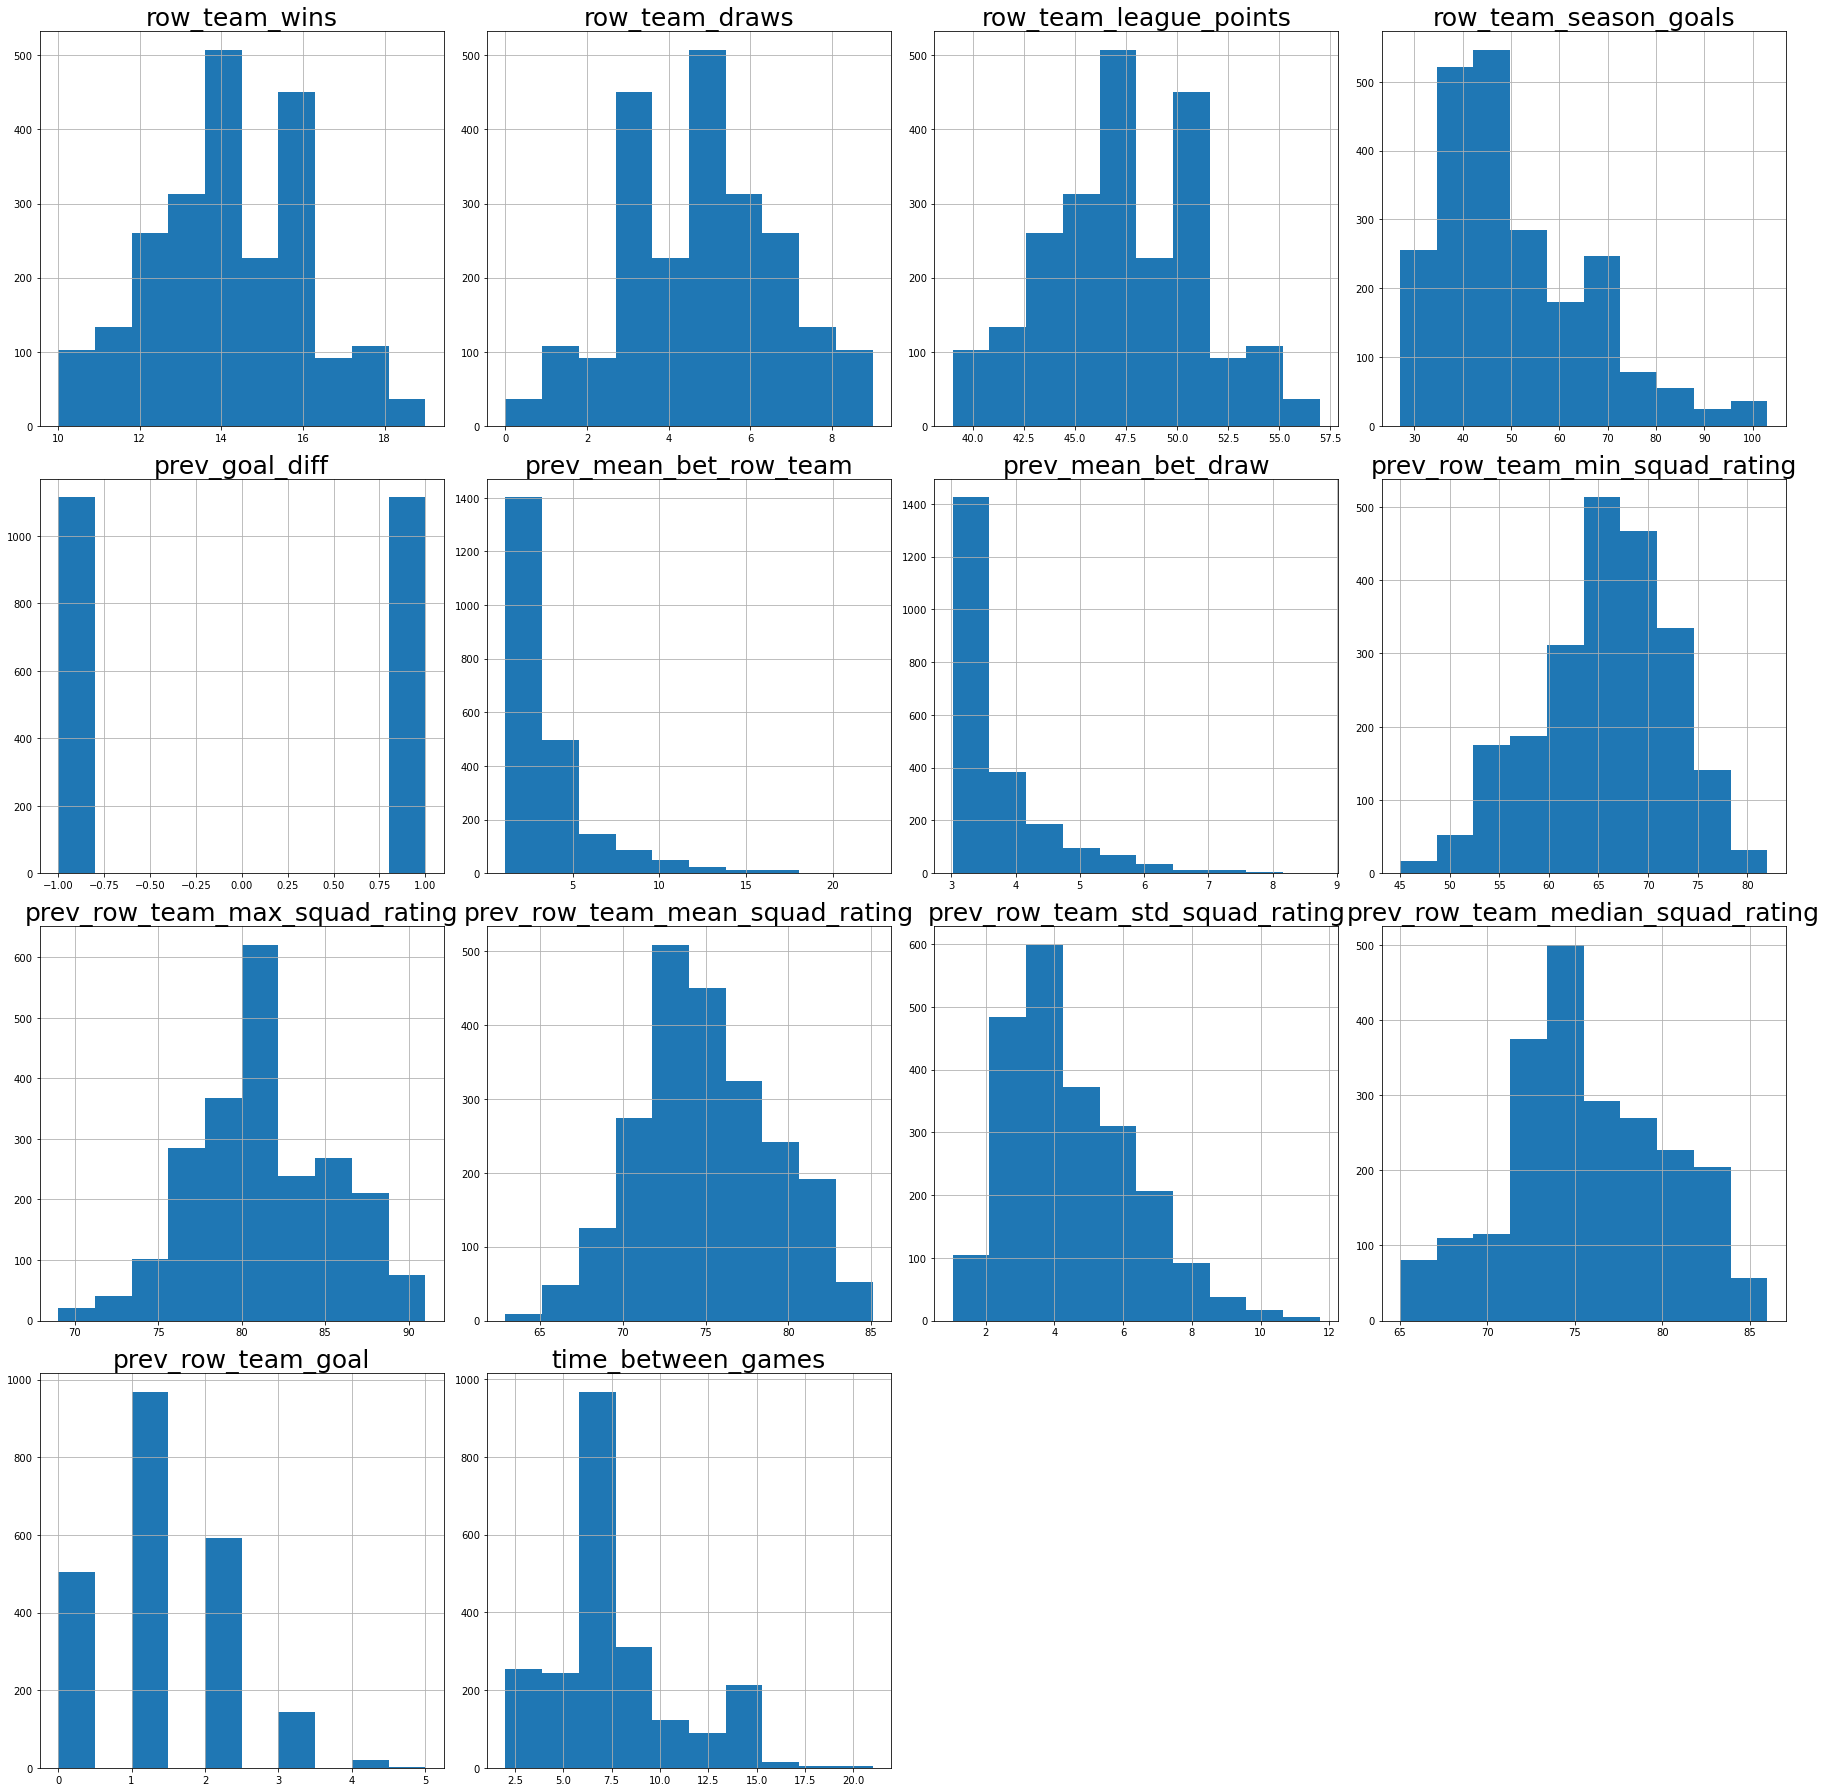

In [9]:
plot_df = df.drop(columns=['row_team', 'league_id', 'prev_date', 'prev_match_api_id', 'next_match_api_id', 'next_date'] + 
        [col for col in df.columns if 'rival' in col or 'next' in col])
fig = plot_df.hist(figsize=(25, 25));
[x.title.set_size(25) for x in fig.ravel()]
plt.tight_layout()

In [10]:
corr_cols = ['row_team_wins', 'row_team_draws', 'row_team_league_points', 'row_team_season_goals', 'prev_goal_diff', 
             'next_goal_diff', 'next_mean_bet_row_team', 'time_between_games',
             'prev_row_team_mean_squad_rating', 'prev_rival_team_mean_squad_rating']

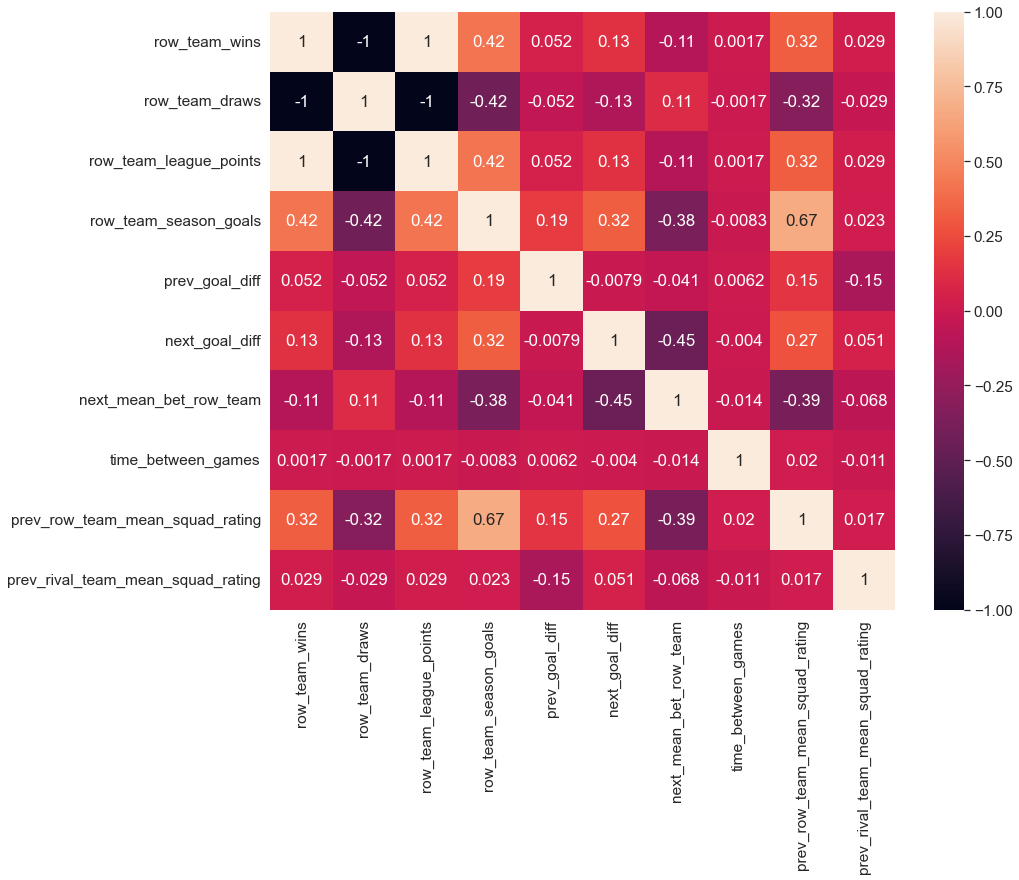

In [18]:
fig, ax = plt.subplots(figsize=(14,11))
sns.heatmap(df[corr_cols].corr(), annot=True, ax=ax)
sns.set(font_scale=1.3)
plt.show()

<AxesSubplot:title={'center':'Treatment Distribution'}, xlabel='Treatment', ylabel='n_samples'>

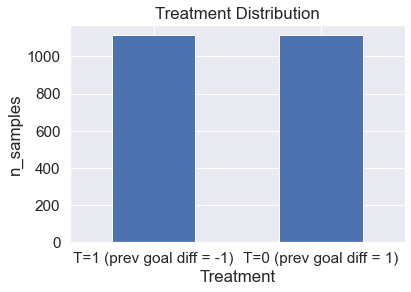

In [12]:
pd.DataFrame({'Treatment': ['T=1 (prev goal diff = -1)', 'T=0 (prev goal diff = 1)'], 
              'n_samples': [len(df[df['prev_goal_diff'] == -1]), len(df[df['prev_goal_diff'] == 1])]})\
                        .plot.bar(x='Treatment', y='n_samples', rot=0, title='Treatment Distribution', legend=False, 
                                  ylabel='n_samples')